<a href="https://colab.research.google.com/github/Paulinebt-ds/OC-Projects/blob/main/P8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Déployez un modèle dans le cloud

## Description

Vous êtes Data Scientist dans une très jeune start-up de l'AgriTech, nommée  "Fruits!", qui cherche à proposer des solutions innovantes pour la récolte des fruits.

La volonté de l’entreprise est de préserver la biodiversité des fruits en permettant des traitements spécifiques pour chaque espèce de fruits en développant des robots cueilleurs intelligents.


Votre start-up souhaite dans un premier temps se faire connaître en mettant à disposition du grand public une application mobile qui permettrait aux utilisateurs de prendre en photo un fruit et d'obtenir des informations sur ce fruit.

Pour la start-up, cette application permettrait de sensibiliser le grand public à la biodiversité des fruits et de mettre en place une première version du moteur de classification des images de fruits.

De plus, le développement de l’application mobile permettra de construire une première version de l'architecture Big Data nécessaire.

###Les données
Votre collègue Paul vous indique l’existence d’un jeu de données constitué des images de fruits et des labels associés, qui pourra servir de point de départ pour construire une partie de la chaîne de traitement des données.

###Votre mission
Vous êtes donc chargé de développer dans un environnement Big Data une première chaîne de traitement des données qui comprendra le preprocessing et une étape de réduction de dimension.

Il n’est pas nécessaire d’entraîner un modèle pour le moment.

L’important est de mettre en place les premières briques de traitement qui serviront lorsqu’il faudra passer à l’échelle en termes de volume de données !

###Contraintes
Lors de son brief initial, Paul vous a averti des points suivants :

Vous devrez tenir compte dans vos développements du fait que le volume de données va augmenter très rapidement après la livraison de ce projet. Vous développerez donc des scripts en Pyspark et utiliserez par exemple le cloud AWS pour profiter d’une architecture Big Data (EC2, S3, IAM), basée sur un serveur EC2 Linux.

La mise en œuvre d’une architecture Big Data sous (par exemple) AWS peut nécessiter une configuration serveur plus puissante que celle proposée gratuitement (EC2 = t2.micro, 1 Go RAM, 8 Go disque serveur).
Ce coût, qui devrait rester inférieur à 10 euros pour une utilisation raisonnée, reste à votre charge. L’utilisation d’un serveur local pour la conception, en limitant l’utilisation du serveur EC2 à l’implémentation et aux tests, permet de réduire sensiblement ce coût.

In [1]:
!pip install opencv-contrib-python==3.4.2.17

     |████████████████████████████████| 30.6 MB 1.3 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [2]:
# Import nécessaires
import os
from google.colab import drive
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install pyspark==3.0.0

     |████████████████████████████████| 204.7 MB 23 kB/s 
     |████████████████████████████████| 198 kB 42.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.0-py2.py3-none-any.whl size=205044182 sha256=acf0f7086c47ba81b1ac54f11c919db7f193111f35288ceee0872bdc7a5dae46
  Stored in directory: /root/.cache/pip/wheels/4e/c5/36/aef1bb711963a619063119cc032176106827a129c0be20e301
Successfully built pyspark


In [5]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark
import findspark
findspark.init()


In [6]:
findspark.find()

'/content/spark-3.0.0-bin-hadoop3.2'

In [7]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [8]:
#Affichage de la SparkSession variable
spark

In [9]:
!unzip /content/drive/MyDrive/P8/fruits-360_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: fruits-360/Training/Tomato 3/111_100.jpg  
  inflating: fruits-360/Training/Tomato 3/112_100.jpg  
  inflating: fruits-360/Training/Tomato 3/113_100.jpg  
  inflating: fruits-360/Training/Tomato 3/114_100.jpg  
  inflating: fruits-360/Training/Tomato 3/115_100.jpg  
  inflating: fruits-360/Training/Tomato 3/116_100.jpg  
  inflating: fruits-360/Training/Tomato 3/117_100.jpg  
  inflating: fruits-360/Training/Tomato 3/119_100.jpg  
  inflating: fruits-360/Training/Tomato 3/120_100.jpg  
  inflating: fruits-360/Training/Tomato 3/121_100.jpg  
  inflating: fruits-360/Training/Tomato 3/122_100.jpg  
  inflating: fruits-360/Training/Tomato 3/123_100.jpg  
  inflating: fruits-360/Training/Tomato 3/124_100.jpg  
  inflating: fruits-360/Training/Tomato 3/125_100.jpg  
  inflating: fruits-360/Training/Tomato 3/126_100.jpg  
  inflating: fruits-360/Training/Tomato 3/127_100.jpg  
  inflating: fruits-360/Training/Tomato 3/128_100.jpg

In [10]:
#Path_image : Apple Granny Smith
spark.read.format("image").load("/content/fruits-360/Training/Apple Granny Smith").show

<bound method DataFrame.show of DataFrame[image: struct<origin:string,height:int,width:int,nChannels:int,mode:int,data:binary>]>

In [11]:
from pyspark import SparkContext
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, split

In [12]:
path = "/content/fruits-360/Training/Apple Granny Smith"

In [13]:
image_df = spark.read.format("binaryfile").load(path)
image_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)



In [14]:
image_df = image_df.withColumn('label', split(col('path'), '/').getItem(4))
image_df = image_df.select('path', 'content', 'label')
image_df.show()

+--------------------+--------------------+------------------+
|                path|             content|             label|
+--------------------+--------------------+------------------+
|file:/content/fru...|[FF D8 FF E0 00 1...|Apple Granny Smith|
|file:/content/fru...|[FF D8 FF E0 00 1...|Apple Granny Smith|
|file:/content/fru...|[FF D8 FF E0 00 1...|Apple Granny Smith|
|file:/content/fru...|[FF D8 FF E0 00 1...|Apple Granny Smith|
|file:/content/fru...|[FF D8 FF E0 00 1...|Apple Granny Smith|
|file:/content/fru...|[FF D8 FF E0 00 1...|Apple Granny Smith|
|file:/content/fru...|[FF D8 FF E0 00 1...|Apple Granny Smith|
|file:/content/fru...|[FF D8 FF E0 00 1...|Apple Granny Smith|
|file:/content/fru...|[FF D8 FF E0 00 1...|Apple Granny Smith|
|file:/content/fru...|[FF D8 FF E0 00 1...|Apple Granny Smith|
|file:/content/fru...|[FF D8 FF E0 00 1...|Apple Granny Smith|
|file:/content/fru...|[FF D8 FF E0 00 1...|Apple Granny Smith|
|file:/content/fru...|[FF D8 FF E0 00 1...|Apple Granny

In [ ]:
list_photos = [file for file in os.listdir(path)]
print("Dans la variété Granny Smith, on compte ", len(list_photos)," images")

Dans la variété Granny Smith, on compte  492  images


In [ ]:
list_photos[1:10]

['260_100.jpg',
 '139_100.jpg',
 'r_184_100.jpg',
 '142_100.jpg',
 '164_100.jpg',
 '151_100.jpg',
 '180_100.jpg',
 'r_174_100.jpg',
 'r_259_100.jpg']

In [ ]:
def list_fct(name) :
    list_image_name = [list_photos[i] for i in range(20)]
    return list_image_name

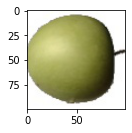

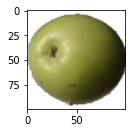

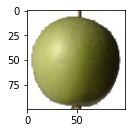

In [ ]:
for i in range(3):
  plt.subplot(130 + 1 + i)
  filename = path+"/"+list_photos[i+10]
  image = imread(filename)
  plt.imshow(image)
  plt.show()

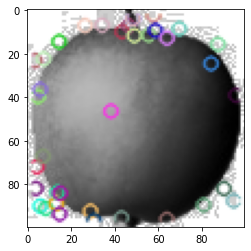


[[133.   1.   1. ...   2.   4.   0.]
 [  1.   1.   0. ...   0.   0.   0.]
 [ 71.  77.  32. ...   1.   0.   0.]
 ...
 [ 83.  46.   0. ...   0.   0.   3.]
 [151.   0.   0. ...   0.   0.   1.]
 [  1.   0.   0. ...   0.   0.   2.]]
(40, 128)


In [ ]:
# load image in gray scale
# create SIFT dectector
SIFT = cv2.xfeatures2d.SIFT_create()  # default features is 50
image = cv2.imread(path+"/"+list_photos[15], 0) # convert in gray
image = cv2.equalizeHist(image)   # equalize image histogram
kp, des = SIFT.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,image)
plt.imshow(img)
plt.show()
print()
print(des)
print(des.shape)

L'image de cette Granny Smith coloré en gris a 40 descripteurs de longueur 128

In [15]:
path = "/content/fruits-360/Training"
list_fruits = [file for file in os.listdir(path)]

In [13]:
len(list_fruits)

131

On a 131 variétés de fruits dans notre base

In [ ]:
list_fruits[1:10]

['Lemon Meyer',
 'Redcurrant',
 'Carambula',
 'Limes',
 'Nectarine Flat',
 'Apple Golden 2',
 'Pepper Red',
 'Tomato 4',
 'Cucumber Ripe']

In [ ]:
list_photos=[]

In [ ]:
for i in range(0, len(list_fruits)):
  print(i)
  i = list_fruits[i]
  print(i)
  path_fruits = path+"/"+i
  print(path_fruits)
  list_photos_i = [file for file in os.listdir(path_fruits)]
  print(len(list_photos_i))
  list_photos.extend(list_photos_i)

0
Tomato 4
/content/fruits-360/Training/Tomato 4
479
1
Apple Crimson Snow
/content/fruits-360/Training/Apple Crimson Snow
444
2
Pomegranate
/content/fruits-360/Training/Pomegranate
492
3
Tomato 3
/content/fruits-360/Training/Tomato 3
738
4
Avocado
/content/fruits-360/Training/Avocado
427
5
Pomelo Sweetie
/content/fruits-360/Training/Pomelo Sweetie
450
6
Mandarine
/content/fruits-360/Training/Mandarine
490
7
Grapefruit White
/content/fruits-360/Training/Grapefruit White
492
8
Kaki
/content/fruits-360/Training/Kaki
490
9
Clementine
/content/fruits-360/Training/Clementine
490
10
Orange
/content/fruits-360/Training/Orange
479
11
Cherry 1
/content/fruits-360/Training/Cherry 1
492
12
Tangelo
/content/fruits-360/Training/Tangelo
490
13
Strawberry Wedge
/content/fruits-360/Training/Strawberry Wedge
738
14
Ginger Root
/content/fruits-360/Training/Ginger Root
297
15
Apple Red Yellow 2
/content/fruits-360/Training/Apple Red Yellow 2
672
16
Dates
/content/fruits-360/Training/Dates
490
17
Cherry Wa

In [ ]:
len(list_photos)

67692

In [ ]:
list_photos[1:10]

['r_54_100.jpg',
 'r_281_100.jpg',
 'r_137_100.jpg',
 'r_304_100.jpg',
 'r_101_100.jpg',
 'r_75_100.jpg',
 'r_265_100.jpg',
 'r_253_100.jpg',
 '327_100.jpg']

In [20]:
all_images_path = '/content/fruits-360/Training/'

In [18]:
image_path = ''
image_folder = all_images_path
for root, directories, files in os.walk(image_folder):
  for file in directories:
      sub_folder = os.path.join(root, file).split('/')[-1]
      image_path = image_path + image_folder + sub_folder + ','
image_path = image_path[0:-1]

In [16]:
image_path[0:1005]

'/content/fruits-360/Training/Onion White,/content/fruits-360/Training/Cantaloupe 2,/content/fruits-360/Training/Pineapple,/content/fruits-360/Training/Grape White 4,/content/fruits-360/Training/Apricot,/content/fruits-360/Training/Lychee,/content/fruits-360/Training/Hazelnut,/content/fruits-360/Training/Apple Granny Smith,/content/fruits-360/Training/Tamarillo,/content/fruits-360/Training/Onion Red,/content/fruits-360/Training/Tomato 4,/content/fruits-360/Training/Apple Red Yellow 1,/content/fruits-360/Training/Potato Red Washed,/content/fruits-360/Training/Mandarine,/content/fruits-360/Training/Apple Red Delicious,/content/fruits-360/Training/Dates,/content/fruits-360/Training/Cucumber Ripe,/content/fruits-360/Training/Banana Lady Finger,/content/fruits-360/Training/Pear Forelle,/content/fruits-360/Training/Cactus fruit,/content/fruits-360/Training/Physalis with Husk,/content/fruits-360/Training/Clementine,/content/fruits-360/Training/Blueberry,/content/fruits-360/Training/Pear Monst

Nombre de descripteurs :  (1979148, 32)
temps de traitement ORB descriptor :           500.57 secondes

In [16]:
!pip install python-resize-image

In [17]:
# System packages
import io
from io import StringIO
import os
import random
import sys
# Table packages
import numpy as np
import pandas as pd
# Images preprocessing packages
from PIL import Image
from resizeimage import resizeimage
import cv2
# Pyspark packages
from pyspark import SparkContext
from pyspark.ml.feature import CountVectorizer
from pyspark.sql import Row, SparkSession 
from sklearn import preprocessing

In [18]:
 # Prints list of random items of folders
nb_folders = 10
random_list_folders = random.sample(list_fruits, nb_folders)
print("Inclus dans la liste aléatoire:", random_list_folders)

Inclus dans la liste aléatoire: ['Apple Red 2', 'Rambutan', 'Corn Husk', 'Huckleberry', 'Cucumber Ripe 2', 'Apple Pink Lady', 'Papaya', 'Mulberry', 'Pepper Green', 'Pomelo Sweetie']


In [21]:
image_path = ''
image_folder = all_images_path
for root, directories, files in os.walk(image_folder):
  for file in directories:
      sub_folder = os.path.join(root, file).split('/')[-1]
      if sub_folder in random_list_folders:
        image_path = image_path + image_folder + sub_folder + ','

In [22]:
image_path = image_path[0:-1]

In [23]:
image_path

'/content/fruits-360/Training/Apple Red 2,/content/fruits-360/Training/Pepper Green,/content/fruits-360/Training/Huckleberry,/content/fruits-360/Training/Rambutan,/content/fruits-360/Training/Corn Husk,/content/fruits-360/Training/Pomelo Sweetie,/content/fruits-360/Training/Apple Pink Lady,/content/fruits-360/Training/Mulberry,/content/fruits-360/Training/Papaya,/content/fruits-360/Training/Cucumber Ripe 2'

In [24]:
def rescale_and_get_descriptors(image):
    """ Map the binaryFiles inputs, returns the category and descriptor.
    
    Transform the binary file into image. If the image is not a square, add a 
    white space to complete it. Thus rescale it to 100*100 pixels-square size. 
    Then apply orb openCV descriptors detection and returns the name of the 
    category as key and the list of descriptors as value.
    """ 
    try:
        # From bytes to image
        name, img = image
        image_img = Image.open(io.BytesIO(img))
        category = name.split('/')[-2]
        # Crop image
        fill_color=(255, 255, 255, 0)
        x, y = image_img.size
        if x < y:
            size_x = y
            size_y = y
        else:
            size_x = x
            size_y = x
        new_im = Image.new('RGB', (size_x, size_y), fill_color)
        new_im.paste(image_img, (int((size_x - x) / 2), int((size_y - y) / 2)))
        img_cropped = new_im
      # Rescale image
        width = 100
        img_rescaled = resizeimage.resize_cover(img_cropped, [width, width])
       # Convert to numpy
        np_img = np.array(image_img)
        # Get descriptors
        SIFT = cv2.xfeatures2d.SIFT_create(nfeatures=30)
        keypoints_sift, desc = SIFT.detectAndCompute(np_img, None)
        # Check if none are found
        if desc is None:
            cat = np.full(1, "error")
        else:
            cat = np.full(desc.shape[0], category)
    except:
        cat = np.full(1, "error")
        desc = None
    return cat, desc

In [25]:
sc = SparkContext.getOrCreate()

In [26]:
from pyspark.sql import Row

In [27]:
images = sc.binaryFiles(image_path)

In [28]:
tuples_decriptors = images.map(lambda img: rescale_and_get_descriptors(img))

In [29]:
descriptors_filtered = tuples_decriptors.filter(lambda x: x[1] is not None)

In [30]:
desc_cat = descriptors_filtered\
    .map(lambda x: (Row(label=x[0], features=x[1].tolist()))).cache()

In [31]:
flat_desc = desc_cat.flatMap(lambda x: x['features'])

In [32]:
flat_cat = desc_cat.flatMap(lambda x: x['label'])

In [33]:
cat_collected = flat_cat.collect()

In [34]:
len(cat_collected)

110196

In [35]:
cat_collected[1]

'Apple Red 2'

In [36]:
type(flat_desc)

pyspark.rdd.PipelinedRDD

In [37]:
flat_desc

PythonRDD[7] at RDD at PythonRDD.scala:53

In [42]:
flat_desc_collected = flat_desc.collect()

In [43]:
len(flat_desc_collected[1])

128

In [44]:
len(flat_desc_collected)

110196

In [38]:
path = "/content/fruits-360/Training"
list_photos = []

In [39]:
for i in range(0, len(random_list_folders)):
  print(i)
  i = random_list_folders[i]
  print(i)
  path_fruits = path+"/"+i
  print(path_fruits)
  list_photos_i = [file for file in os.listdir(path_fruits)]
  print(len(list_photos_i))
  list_photos.extend(list_photos_i)

0
Apple Red 2
/content/fruits-360/Training/Apple Red 2
492
1
Rambutan
/content/fruits-360/Training/Rambutan
492
2
Corn Husk
/content/fruits-360/Training/Corn Husk
462
3
Huckleberry
/content/fruits-360/Training/Huckleberry
490
4
Cucumber Ripe 2
/content/fruits-360/Training/Cucumber Ripe 2
468
5
Apple Pink Lady
/content/fruits-360/Training/Apple Pink Lady
456
6
Papaya
/content/fruits-360/Training/Papaya
492
7
Mulberry
/content/fruits-360/Training/Mulberry
492
8
Pepper Green
/content/fruits-360/Training/Pepper Green
444
9
Pomelo Sweetie
/content/fruits-360/Training/Pomelo Sweetie
450


In [40]:
len(list_photos)

4738

In [45]:
type(flat_desc_collected)

list

In [46]:
flat_desc_data = pd.DataFrame.from_dict({"features": flat_desc_collected}) 

In [47]:
flat_desc_data

,features
0,"[10.0, 0.0, 0.0, 0.0, 5.0, 32.0, 7.0, 8.0, 65...."
1,"[9.0, 2.0, 0.0, 0.0, 2.0, 4.0, 1.0, 3.0, 155.0..."
2,"[19.0, 0.0, 0.0, 0.0, 4.0, 7.0, 2.0, 5.0, 129...."
3,"[20.0, 11.0, 0.0, 0.0, 0.0, 2.0, 2.0, 4.0, 157..."
4,"[17.0, 15.0, 3.0, 4.0, 5.0, 1.0, 0.0, 3.0, 181..."
...,...
110191,"[86.0, 38.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 193..."
110192,"[1.0, 11.0, 8.0, 5.0, 18.0, 7.0, 0.0, 0.0, 137..."
110193,"[67.0, 18.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 198..."
110194,"[65.0, 10.0, 1.0, 3.0, 5.0, 0.0, 0.0, 0.0, 198..."


In [48]:
flat_desc_data["category"]=cat_collected

In [49]:
flat_desc_data

,features,category
0,"[10.0, 0.0, 0.0, 0.0, 5.0, 32.0, 7.0, 8.0, 65....",Apple Red 2
1,"[9.0, 2.0, 0.0, 0.0, 2.0, 4.0, 1.0, 3.0, 155.0...",Apple Red 2
2,"[19.0, 0.0, 0.0, 0.0, 4.0, 7.0, 2.0, 5.0, 129....",Apple Red 2
3,"[20.0, 11.0, 0.0, 0.0, 0.0, 2.0, 2.0, 4.0, 157...",Apple Red 2
4,"[17.0, 15.0, 3.0, 4.0, 5.0, 1.0, 0.0, 3.0, 181...",Apple Red 2
...,...,...
110191,"[86.0, 38.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 193...",Cucumber Ripe 2
110192,"[1.0, 11.0, 8.0, 5.0, 18.0, 7.0, 0.0, 0.0, 137...",Cucumber Ripe 2
110193,"[67.0, 18.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 198...",Cucumber Ripe 2
110194,"[65.0, 10.0, 1.0, 3.0, 5.0, 0.0, 0.0, 0.0, 198...",Cucumber Ripe 2


In [50]:
sift_keypoints_by_img = np.asarray(flat_desc_collected)

In [51]:
sift_keypoints_by_img.shape

(110196, 128)

In [52]:
keypoints_data = pd.DataFrame(sift_keypoints_by_img)

In [53]:
keypoints_data

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,10.0,0.0,0.0,0.0,5.0,32.0,7.0,8.0,65.0,10.0,...,1.0,23.0,149.0,51.0,0.0,0.0,0.0,0.0,0.0,6.0
1,9.0,2.0,0.0,0.0,2.0,4.0,1.0,3.0,155.0,18.0,...,0.0,28.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2,19.0,0.0,0.0,0.0,4.0,7.0,2.0,5.0,129.0,6.0,...,0.0,65.0,14.0,0.0,0.0,1.0,1.0,2.0,1.0,3.0
3,20.0,11.0,0.0,0.0,0.0,2.0,2.0,4.0,157.0,73.0,...,0.0,85.0,9.0,0.0,0.0,0.0,0.0,0.0,2.0,8.0
4,17.0,15.0,3.0,4.0,5.0,1.0,0.0,3.0,181.0,26.0,...,0.0,27.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110191,86.0,38.0,0.0,0.0,0.0,2.0,2.0,2.0,193.0,131.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
110192,1.0,11.0,8.0,5.0,18.0,7.0,0.0,0.0,137.0,157.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
110193,67.0,18.0,1.0,1.0,1.0,0.0,0.0,0.0,198.0,75.0,...,0.0,19.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
110194,65.0,10.0,1.0,3.0,5.0,0.0,0.0,0.0,198.0,49.0,...,0.0,17.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## PCA

In [ ]:
#data = [(Vectors.sparse(5, [(1, 1.0), (3, 7.0)]),),
  #  (Vectors.dense([2.0, 0.0, 3.0, 4.0, 5.0]),),
   # (Vectors.dense([4.0, 0.0, 0.0, 6.0, 7.0]),)]

# Pour faire la PCA, créer des Vectors.dense à partir de keypoints_data ou flat_desc_data

In [97]:
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf

In [54]:
source_data = flat_desc_data["features"].values

In [55]:
source_data

array([list([10.0, 0.0, 0.0, 0.0, 5.0, 32.0, 7.0, 8.0, 65.0, 10.0, 0.0, 0.0, 6.0, 27.0, 12.0, 67.0, 47.0, 8.0, 0.0, 0.0, 0.0, 0.0, 1.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 1.0, 0.0, 0.0, 12.0, 14.0, 1.0, 7.0, 170.0, 69.0, 0.0, 0.0, 23.0, 24.0, 2.0, 18.0, 180.0, 81.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 48.0, 9.0, 0.0, 0.0, 3.0, 7.0, 2.0, 5.0, 135.0, 16.0, 0.0, 0.0, 8.0, 31.0, 13.0, 29.0, 180.0, 103.0, 0.0, 0.0, 0.0, 0.0, 1.0, 59.0, 78.0, 23.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 65.0, 5.0, 0.0, 0.0, 0.0, 0.0, 1.0, 11.0, 44.0, 19.0, 0.0, 0.0, 8.0, 16.0, 8.0, 12.0, 180.0, 174.0, 0.0, 0.0, 2.0, 3.0, 1.0, 23.0, 149.0, 51.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]),
       list([9.0, 2.0, 0.0, 0.0, 2.0, 4.0, 1.0, 3.0, 155.0, 18.0, 0.0, 0.0, 3.0, 7.0, 1.0, 8.0, 184.0, 53.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 38.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 11.0, 2.0, 5.0, 5.0, 1.0, 1.0, 0.0, 4.0, 183.0, 18.0, 5.0, 6.0, 1.0, 2.0, 0.0, 10.0, 184.0, 43.0, 0.0, 0.0, 0.0,

In [56]:
df = spark.createDataFrame(source_data, ["features"])

In [57]:
df

DataFrame[features: double, _2: double, _3: double, _4: double, _5: double, _6: double, _7: double, _8: double, _9: double, _10: double, _11: double, _12: double, _13: double, _14: double, _15: double, _16: double, _17: double, _18: double, _19: double, _20: double, _21: double, _22: double, _23: double, _24: double, _25: double, _26: double, _27: double, _28: double, _29: double, _30: double, _31: double, _32: double, _33: double, _34: double, _35: double, _36: double, _37: double, _38: double, _39: double, _40: double, _41: double, _42: double, _43: double, _44: double, _45: double, _46: double, _47: double, _48: double, _49: double, _50: double, _51: double, _52: double, _53: double, _54: double, _55: double, _56: double, _57: double, _58: double, _59: double, _60: double, _61: double, _62: double, _63: double, _64: double, _65: double, _66: double, _67: double, _68: double, _69: double, _70: double, _71: double, _72: double, _73: double, _74: double, _75: double, _76: double, _77: 

In [102]:
to_vector = udf(lambda a: Vectors.dense(a), VectorUDT())

In [107]:
data = df.select(to_vector("features").alias("features"))

AttributeError: ignored

In [58]:
from pyspark.mllib.feature import StandardScaler
scaler1 = StandardScaler().fit(flat_desc)
scaler2 = StandardScaler(withMean=True, withStd=True).fit(flat_desc)
label = flat_cat
# data1 will be unit variance.
data1 = label.zip(scaler1.transform(flat_desc))

# data2 will be unit variance and zero mean.
data2 = label.zip(scaler2.transform(flat_desc.map(lambda x: Vectors.dense(x.toArray()))))

In [157]:
type(data2)

pyspark.rdd.RDD

In [163]:
mySchema = StructType([ StructField("features", ArrayType(FloatType()), True)])

In [164]:
features_scaled = spark.createDataFrame(data2, schema=mySchema)

In [154]:
from pyspark.ml.feature import PCA
pca = PCA(k=int(110196*0.99), inputCol="features")
pca.setOutputCol("pca_features")

PCA_0bd2d304d9fb

In [165]:
model = pca.fit(features_scaled)
model.getK()

IllegalArgumentException: ignored

## Création des clusters de descripteurs

In [ ]:
len(np.unique(cat_collected))

131

In [59]:
from pyspark.mllib.clustering import KMeans
K = len(np.unique(flat_cat))*10
model_kmeans =  KMeans.train(flat_desc, K, maxIterations=1000, initializationMode="random")

In [60]:
 # Get the results of clustering
transformed = model_kmeans.predict(flat_desc)
# Collect
predictions = transformed.collect()

In [61]:
type(predictions)

list

In [62]:
predictions[1:10]

[9, 9, 9, 3, 4, 9, 8, 0, 2]

In [63]:
len(predictions)

110196

In [64]:
flat_desc_data["predictions"] = predictions

In [157]:
flat_desc_data.to_csv("/content/drive/MyDrive/P8/features_parq.csv")

In [158]:
import pyarrow as pa
import pyarrow.parquet as pq
table = pa.Table.from_pandas(flat_desc_data, preserve_index=True)
pq.write_table(table,"/content/drive/MyDrive/P8/features_parq.parquet")

## Création du bag of words

In [135]:
type(cat_collected)

list

Documentation sur les types supportés en spark, le numpy.str_ s'apparenterait au BinaryType() plutôt qu'au StringType
https://spark.apache.org/docs/latest/api/python/user_guide/pandas_on_spark/types.html?highlight=to_pandas

In [161]:
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, BinaryType, ArrayType, FloatType
mySchema = StructType([ StructField("label", StringType(), True)])

In [93]:
df_cat_pd = pd.DataFrame(cat_collected, columns=["label"])

In [96]:
!pip install pyspark.pandas

  Created wheel for pyspark.pandas: filename=pyspark_pandas-0.0.7-py3-none-any.whl size=7860 sha256=8a4fb9a44161c3b4c3ecbdb51d14829910a676ac25017583900ea8ace5ffb319
  Stored in directory: /root/.cache/pip/wheels/b3/fb/fa/a514a87218dddb592f879419706e25351cd8022edbe90d4953
Successfully built pyspark.pandas


In [111]:
string_category = []

In [112]:
for i in df_cat_pd.label.values : 
  converted_value = getattr(i, "tolist", lambda: i)()
  string_category.append(converted_value)

In [113]:
type(string_category[1])

str

In [116]:
df_cat_pd = pd.DataFrame(string_category, columns=["label"])

In [117]:
df_cat_spark = spark.createDataFrame(df_cat_pd)

In [118]:
### Get datatype of label column

df_cat_spark.select("label").dtypes

## Label est de type binary

[('label', 'string')]

In [ ]:
from pyspark.ml.feature import CountVectorizer, StringIndexer
# Convert string labels of categories to floats
label_indexer = StringIndexer(inputCol="label", outputCol="label_index")
label_indexer_transformer = label_indexer.fit(df_cat_spark)
label_indexer_transformed = label_indexer_transformer.transform(df_cat_spark)

In [123]:
flat_desc_data["category"] = string_category

In [121]:
flat_desc_data["label_category"] = label_indexer_transformed

In [127]:
flat_desc_data.predictions.dtypes

dtype('int64')

In [141]:
predictions = [str(item) for item in predictions]

In [142]:
type(predictions[1])

str

In [149]:
mySchema = StructType([ StructField("predictions", ArrayType(StringType()), True)])

In [151]:
# Convert list to RDD
rdd = spark.sparkContext.parallelize(predictions)
# Create data frame
predictions_spark = spark.createDataFrame(rdd,mySchema)
print(predictions_spark.schema)

StructType(List(StructField(predictions,ArrayType(StringType,true),true)))


In [150]:
predictions_spark = spark.createDataFrame(predictions, schema=mySchema)

TypeError: ignored

In [152]:
# Learn the vocabulary of our training data
vectorizer = CountVectorizer(inputCol="predictions", outputCol="bag_of_words")
vectorizer_transformer = vectorizer.fit(predictions_spark)

# Create bags of words for train data
train_bag_of_words = vectorizer_transformer.transform(predictions_spark)

bag_of_words = train_bag_of_words\
    .map(lambda x: (Row(features=x["features"], bag_of_words=x["bag_of_words"].tolist()))).cache()

Py4JJavaError: ignored

In [168]:
!pip install boto

     |████████████████████████████████| 1.4 MB 4.2 MB/s 


In [170]:
!pip install boto3

     |████████████████████████████████| 132 kB 5.6 MB/s 
     |████████████████████████████████| 8.6 MB 33.1 MB/s 
     |████████████████████████████████| 79 kB 6.3 MB/s 
     |████████████████████████████████| 138 kB 35.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.8 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


## Connexion à S3

In [1]:
# Write on S3
import boto.s3
import boto3


In [2]:
all_images_path = "s3://p8fruits/fruits-360/Training/"

In [7]:
conn = boto.s3.connect_to_region('eu-west-3')

In [8]:
contents = conn.list_objects(Bucket='p8fruits', Prefix='fruits-360')['Contents']
for file in contents:
    print(file['Key']) 

AttributeError: ignored

In [5]:
connexion = boto3.client('s3')


NoCredentialsError: ignored